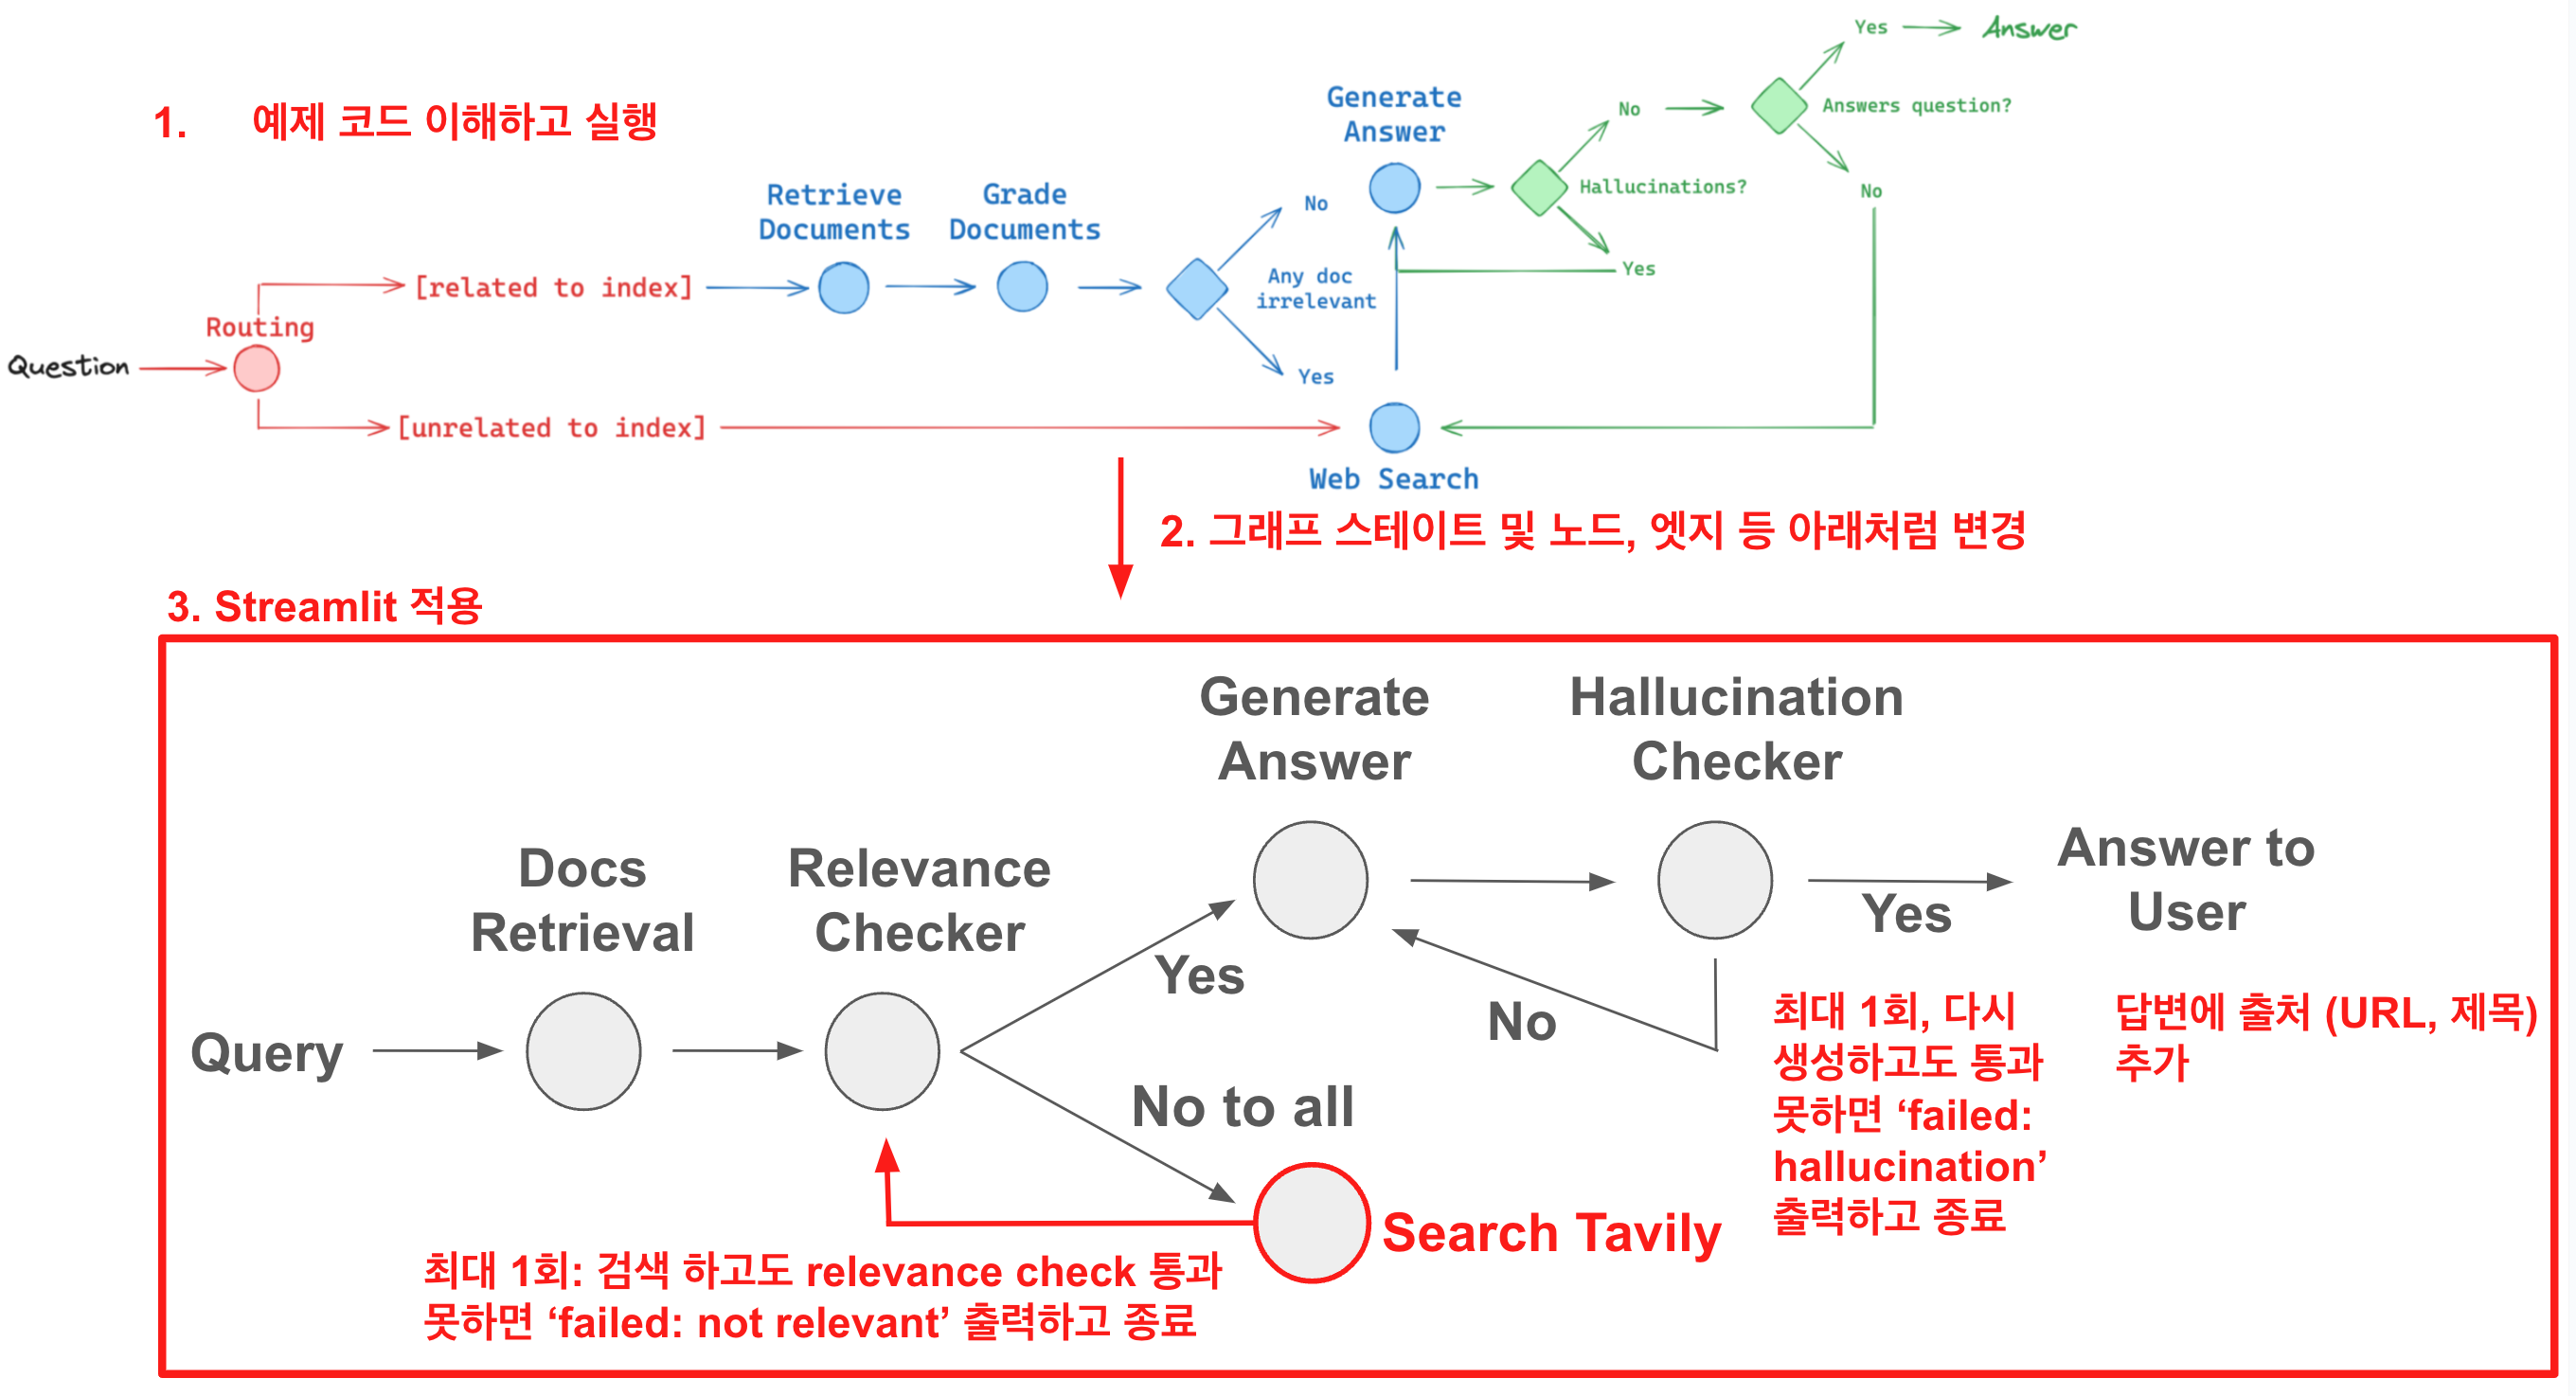

In [102]:
%%capture --no-stderr
%pip install langchain_community langchainhub chromadb langchain langgraph tavily-python langchain-text-splitters langchain_openai

In [ ]:
from langchain_openai import ChatOpenAI
import os
os.environ['OPENAI_API_KEY'] = ''

llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0)

In [104]:
### Index

from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vectorstore.as_retriever()

In [105]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n context: {context} "),
    ]
)
rag_chain = prompt | llm | StrOutputParser()

In [ ]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from tavily import TavilyClient

system = """You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n document: {document} "),
    ]
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "What is prompt?"
docs = retriever.invoke(question)
relevance = retrieval_grader.invoke({"question": question, "document": docs[0].page_content})

from tavily import TavilyClient
tavily = TavilyClient(api_key='')

def web_search(question: str) -> list[Document]:
    docs = tavily.search(query=question)['results']
    print(docs)
    web_results = "\n".join([d["content"] for d in docs])
    documents = [Document(page_content=web_results)]
    return documents

if relevance['score'] == 'no':
    docs = web_search(question)
    relevance = retrieval_grader.invoke({"question": question, "document": docs[0].page_content})

generation = rag_chain.invoke({"context": docs, "question": question})

In [107]:
### Hallucination Grader

system = """You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation. yes라면 JSON에 reference란 속성에 참고한 documents 의 url 및 페이지 title을 알려줘"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "documents: {documents}\n\n answer: {generation} "),
    ]
)

hallucination_grader = prompt | llm | JsonOutputParser()

hall_result = hallucination_grader.invoke({"documents": docs, "generation": generation})
# hall_result = hallucination_grader.invoke({"documents": "오늘 오후에는 전국에 걸쳐 소나기가 내릴 예정입니다.", "generation": generation})
print(generation)
print('hallucination', hall_result)

if (hall_result['score'] == 'no'):
    generation = rag_chain.invoke({"context": docs, "question": question})
    hall_result = hallucination_grader.invoke({"documents": docs, "generation": generation})
    print(generation)
    print('hallucination', hall_result)



A prompt is a sequence of prefix tokens designed to increase the likelihood of obtaining a desired output from a language model given a specific input. It can be treated as a trainable parameter and optimized using methods like AutoPrompt and Prompt-Tuning. The goal of prompt engineering is to effectively communicate with the model to achieve specific outcomes without altering its weights.
hallucination {'score': 'yes', 'reference': {'url': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}}
